Itt látható egy LSTM cell 3 unitja, annyi unit ahány input. Itt az inputok vektorok.


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/10131302/13.png)

Ez pedig egy ellentétes irányú RNN, de mi nem ilyet csinálunk (tudtommal), csak ez volt a legszemléletesebb ábrám hozzá.

![alt text](https://miro.medium.com/max/790/1*GRQ91HNASB7MAJPTTlVvfw.jpeg)

In [0]:
#import

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

!wget http://users.itk.ppke.hu/~nagad2/resources/electrical_devs/ElectricDevices_TEST.dms
!wget http://users.itk.ppke.hu/~nagad2/resources/electrical_devs/ElectricDevices_TRAIN.dms

with open('ElectricDevices_TEST.dms', 'r') as f:
  test_file = f.read()

with open('ElectricDevices_TRAIN.dms', 'r') as f:
  train_file = f.read()

train_file = train_file.split('\n')
train_data = np.zeros((len(train_file), 96))
train_labels = np.zeros((len(train_file), 1))

for ind,t in enumerate(train_file):
  d = t.split(',')
  if d[0] != "":
    train_labels[ind] = int(d[0])-1  
    train_data[ind, :] = np.asarray(d[1:])

test_file = test_file.split('\n')
test_data = np.zeros((len(test_file), 96))
test_labels = np.zeros((len(test_file), 1))

--2019-12-14 06:59:04--  http://users.itk.ppke.hu/~nagad2/resources/electrical_devs/ElectricDevices_TEST.dms
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6307707 (6.0M) [application/x-dms]
Saving to: ‘ElectricDevices_TEST.dms’

ElectricDevices_TES 100%[===================>]   6.01M   925KB/s    in 6.8s    

2019-12-14 06:59:16 (909 KB/s) - ‘ElectricDevices_TEST.dms’ saved [6307707/6307707]

--2019-12-14 06:59:18--  http://users.itk.ppke.hu/~nagad2/resources/electrical_devs/ElectricDevices_TRAIN.dms
Resolving users.itk.ppke.hu (users.itk.ppke.hu)... 193.225.109.33
Connecting to users.itk.ppke.hu (users.itk.ppke.hu)|193.225.109.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7302704 (7.0M) [application/x-dms]
Saving to: ‘ElectricDevices_TRAIN.dms’

ElectricDevices_TRA 100%[===================>]   6.96M

Input shape: (8927, 96)
Expected output shape: 1
Expected output random element: [6.]
Expected output all variations of the elements: [0. 1. 2. 3. 4. 5. 6.]
<class 'tensorflow.python.framework.ops.Tensor'>
Iteration: 0, loss: 1.8980263, accuracy: 0.09375
Iteration: 100, loss: 1.6493831, accuracy: 0.21875
Iteration: 200, loss: 1.5778407, accuracy: 0.234375
Iteration: 300, loss: 1.4814237, accuracy: 0.265625
Iteration: 400, loss: 1.5661464, accuracy: 0.28125
Iteration: 500, loss: 1.3486207, accuracy: 0.375
Iteration: 600, loss: 1.5012525, accuracy: 0.359375
Iteration: 700, loss: 1.4718614, accuracy: 0.28125
Iteration: 800, loss: 1.4379063, accuracy: 0.375
Iteration: 900, loss: 1.3203888, accuracy: 0.375
Iteration: 1000, loss: 1.5441461, accuracy: 0.3125
Iteration: 1100, loss: 1.2872099, accuracy: 0.453125
Iteration: 1200, loss: 1.3655646, accuracy: 0.34375
Iteration: 1300, loss: 1.297282, accuracy: 0.359375
Iteration: 1400, loss: 1.271781, accuracy: 0.34375
Iteration: 1500, loss: 1.27041

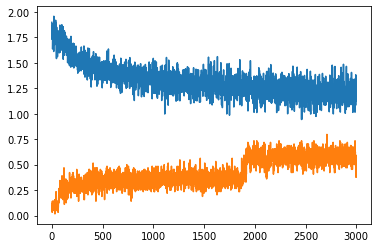

In [0]:
#finding the data and the label shapes

print('Input shape: ' + str(train_data.shape))

#Ebből látszik, hogy nem one_hot
print('Expected output shape: ' + str(train_labels.shape[1]))
print('Expected output random element: ' + str(train_labels[2352]))
#megnézzük az elemeit, és látszik, hogy 7 féle opciónk van
print('Expected output all variations of the elements: ' + str(np.unique(train_labels)))


#hyperparameters

#azért kell 2 dimenzió, mivel az input egy egész vektor lesz
input_shape = [train_data.shape[1], 1]
batch_size = 64
#a uniqueból látszik, hogy nem használhatjuk a label shapjét, mert nem one_hot
#de ilyenkor lekérhetjük a fentebb megnézett tömb méretét
num_classes = len(np.unique(train_labels))
state_size = [1, 16, 32]
fully_layers = [state_size[-1], 16, num_classes]
num_iterations = 3000


#graph building

tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [batch_size] + input_shape)
#azért int32, mert a tf.one_hot csak azt tudja megenni
expected_output = tf.placeholder(tf.int32, [batch_size])

#itt teszzük one_hot formára, hogy tudjuk használni
one_hot_labels = tf.one_hot(expected_output, num_classes)

#ebbe fogjuk tárolni az RNN celláinkat
cells = []

#végigiterálunk az állapotokon
for i in range(len(state_size)-1):

  #létrehozunk egy cellát majd betöltjük a cells[] be
  #nem muszáj LSTMet, de mi azt használtuk
  #num_units: int, The number of units in the LSTM cell
  #num_proj: (optional) int, The output dimensionality for the projection matrices. If None, no projection is performed.
  cell = tf.nn.rnn_cell.LSTMCell(num_units=state_size[i], num_proj=state_size[i+1])
  cells.append(cell)

#készít egy rnn cellát szekvenciálisan a tömbben lévő egyszerű cellákból
multi_layer_rnn = tf.nn.rnn_cell.MultiRNNCell(cells)

#elkészíti az RNN-t magát
#'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]
#'state' is a tensor of shape [batch_size, cell_state_size]
outputs, state = tf.nn.dynamic_rnn(multi_layer_rnn, input_data, dtype=tf.float32)

#az utolsó állapotunkat lekérjük, hogy odaadhassuk a fullyconnectednek
current_input = state[-1][-1]

#csak egy szokásos fullyconnected
for i in range(len(fully_layers)-1):
  with tf.variable_scope('layer' + str(i)):

    #ezeket a változókat nem akarjuk "tanítani"
    w = tf.get_variable('w', [fully_layers[i], fully_layers[i+1]], trainable=False)
    b = tf.get_variable('b', [fully_layers[i+1]], trainable=False)
    current_input = tf.matmul(current_input, w)
    current_input = tf.add(current_input, b)

    if(i != len(fully_layers)-2):
      current_input = tf.nn.relu(current_input)


with tf.variable_scope('loss'):
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=current_input))

with tf.variable_scope('optimizer'):
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.variable_scope('accuracy'):
  accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(one_hot_labels, 1), tf.argmax(current_input, 1)), tf.float32))


#session

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  loss_plot = np.zeros(num_iterations)
  acc_plot = np.zeros(num_iterations)

  for i in range(num_iterations):
    used_in_batch = random.sample(range(len(train_data)), batch_size)
    batch_x = np.reshape(train_data[used_in_batch], [batch_size] + input_shape)
    batch_y = np.reshape(train_labels[used_in_batch], [batch_size])

    _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={input_data: batch_x, expected_output: batch_y})

    loss_plot[i] = l
    acc_plot[i] = acc

    if(i%100 == 0):
      print('Iteration: ' + str(i) + ', loss: ' + str(l) + ', accuracy: ' + str(acc))

plt.plot(loss_plot)
plt.plot(acc_plot)
